# Recommender System

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

# Familiarization

First, we will load the entire dataset and visualize it to get a first look at what we are dealing with. We have decided to visualize the given data as a matrix where on column i we can see which people the person with id i liked/disliked by checking each line and putting either a green dot if they liked the person with id j (line j), or a red dot if they disliked them.

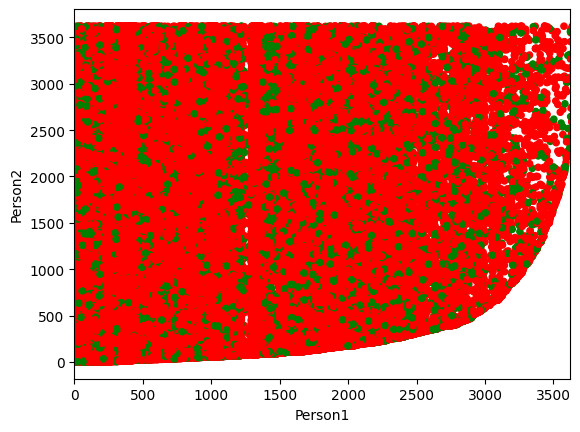

In [199]:
train_file_path = 'lab2_train.csv'

pd.set_option('display.max_rows', None)
train_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)
#dropping the column related to matches as is mentioned in the assignment description
train_data = train_data.drop('is_match',axis=1)

def visualize_data(df, window=None, title=None):
    if window is None:
        start_index = 0
        end_index = train_data['user_to_id'].max()
    else:
        start_index, end_index = window
    colors = df['is_like'].map({True: 'green', False: 'red'})
    plt.scatter(df['user_from_id'], df['user_to_id'], c=colors, s=20)

    plt.xlim(start_index,end_index)

    plt.xlabel('Person1')
    plt.ylabel('Person2')

    if title is not None:
        plt.title(title)

    plt.show()

visualize_data(train_data)

On a first glance, one can easily see that users with id greater than ~2500 rate(like/dislike) a lot less than the others. There are also certain groups(intervals of columns) of people that like a lot/dislike a lot. To show a couple of examples, we will plot a few smaller window of columns that demonstrate users that mostly dislike others, and also print a list of the people who have only ever liked others, without any dislikes.

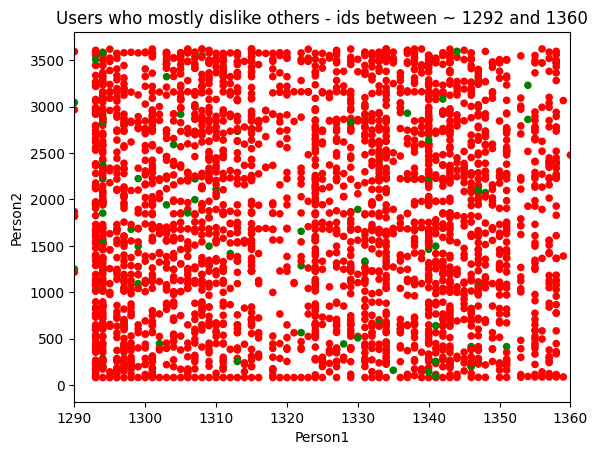

Partial ist of the ids of users who only liked others.
[3604, 3608, 3212, 3663, 3674, 7, 2530, 3607, 2907, 3050]


In [200]:
visualize_data(train_data, (1290,1360), "Users who mostly dislike others - ids between ~ 1292 and 1360")

id_counts = list(train_data[(train_data['is_like'] == True) | (train_data['is_like'] == False)]['user_from_id'].value_counts().items())
filtered_data = train_data[train_data['is_like'] == True]
like_counts = list(filtered_data['user_from_id'].value_counts().items())

all_likes_tuples = list(set(id_counts) & set(like_counts))
all_likes = [v[0] for v in all_likes_tuples]
print("Partial ist of the ids of users who only liked others.")
print(all_likes[:10])

Thus, we can observe that multiple types of people exist in our dataset. There are also examples of intervals where a lot of users did not have any type of interaction, i.e between 1250 and 1300, most users seem to not have many if any interactions at all.

# Preprocessing

 First, we will have to do some preprocessing on our training dataframe. After a lot of trial and error, we have decided to:
- remove the duplicate lines, only keeping unique instances of lines
- remove rows where a user first liked a person and then disliked them, or the other way around(due to inconsistency in data) Example: user 1 liked user 2, and then disliked them afterwards. We are deleting both rows.
- remove ids of users who have never liked someone, meaning either only dislikes
- remove ids of people who have less than a certain threshold of interactions(times they appear in the dataframe) 

In our tests, the removal of such outliers has shown to improve our algorithm's accuracy and, at the same time, make a lot of sense to us in order to maintain consistency and fairness in our data. In order to put in practice the above points, we created the function below that takes a dataframe and returns a filtered one:

In [201]:
def preprocess(data, min_interactions = 5):
    # removing duplicate lines
    train_data = data
    train_data = train_data.drop_duplicates()
    
    # removing inconsistent ids(described above)
    mask = train_data.duplicated(subset=['user_from_id', 'user_to_id'],keep=False)
    train_data = train_data[~mask]

    # removing ids that have only disliked others
    false_ids = train_data.loc[~train_data.groupby('user_from_id')['is_like'].transform('any')]['user_from_id'].to_list() #list of ids to be removed
    train_data = train_data[~train_data['user_from_id'].isin(false_ids)]
    
    # removing ids of people with a small amount of interactions
    counts_list = list(train_data['user_from_id'].value_counts().items())
    relevant_ids = [id for id, count in counts_list if count>=min_interactions]
    train_data = train_data[train_data['user_from_id'].isin(relevant_ids)]
    train_data = train_data.reset_index(drop=True)
    return train_data

To better visualize the effects of our pre-processing, let's see its effects on the following, simpler, dataset:

In [212]:
simple_train_file_path = 'simple_train.csv'
simple_train_data = pd.read_csv(simple_train_file_path, delimiter=',', skipinitialspace= True)
simple_train_data = simple_train_data.drop('is_match',axis=1)
print(simple_train_data)

    user_from_id  user_to_id  is_like
0           1136        3141     True
1           1136        3174    False
2           1136        3590    False
3            800        2736    False
4            883         437     True
5            311         625    False
6              8        1122    False
7            883         437     True
8            883         437    False
9              1           2     True
10           883          23     True
11           883          32    False
12             1           3     True
13             1           4     True
14             1           5     True
15             1           6     True
16             1           6     True
17           311       53243    False
18           311          23    False
19           311         543    False
20           311      345325    False


In [213]:
# Filtering our data
filtered_simple_data = preprocess(simple_train_data,2)
print(filtered_simple_data)

   user_from_id  user_to_id  is_like
0          1136        3141     True
1          1136        3174    False
2          1136        3590    False
3             1           2     True
4           883          23     True
5           883          32    False
6             1           3     True
7             1           4     True
8             1           5     True
9             1           6     True


Here, we can see the effects of our preprocessing: 
- The like from user 1 to user 6 only appears once
- User 883 liked 437 twice and disliked once, thus we don't include the matching of 883 to 437 at all
- User 311 only disliked users (many interactions though), so it is not included
- Users 800 and 8 only had one interaction

# NMF-based recommender system
We will now apply our NMF algorithm on the dataset in order to then reconstruct the matrix for a proper recommender system.

!!! SCRIE AICI IONITA !!!

# Distance-based recommender system

Next, we will adopt a different approach to the task of coming up with a new recommendation for a user. To build a basic intuition, we will first build a new utility matrix where both rows and columns each contain distinct user ids, and a 1 in row `i`, column `j`, would signify that user with id `j` liked user with id `i`.

Next, in order to identify two users with similar behaviour, one can directly compute the Jaccard distance between two columns and consider pairs that are very "close" to each other. To optimize issues with sparsity in data and adopt an automatic feature extraction technique, we will use min-hashing to compute a signature for each column, and then only compare these signatures.

This is the function that computes the algorithm:

In [204]:
class HashFunction:
    """
    This HashFunction class can be used to create a unique hash given a seed (useful for the reproducibility of results)
    """
    def __init__(self, seed, bigPrime = 805306457):
        self.bigPrime = bigPrime
        self.seed = seed
        random.seed(seed)
        self.alpha = random.choice(range(1,bigPrime))
        self.beta = random.choice(range(0,bigPrime))

    def compute_value(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: Defining the range of outputs of the function [0,n-1]
        :return: The hashed value x given the seed
        """
        return ((self.alpha * x + self.beta) % self.bigPrime)  % n

def compute_signature(ids: list[set[int]], number_hash_functions = 100, hashes_seed = 32):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param ids: The list of sets of ids -> the i-th element in this list represent the users liked by the i-th user
    :param number_hash_functions: The number of hash function we will be using
    :param hashes_seed: The seed for generating the list of seeds, used for generating the hash functions
    :return: The MinHash signature matrix for the given sets of ids, with number_hash_functions rows and as many columns as users for which have liked someone else
    """
    
    # First we need to generate the hash functions we will be using - note that the actual hash functions will be different between them, but the same in every run 
    random.seed(hashes_seed)
    hash_functions = [HashFunction(random.random()) for _ in range(number_hash_functions)]
    
    # This will be the matrix we return
    result = np.full((number_hash_functions, len(ids)), sys.maxsize)
    
    # A sorted set of the ids of the liked users (Defining the columns of the utility matrix)
    sorted_space = sorted(set().union(*ids))

    # For each liked user B
    for row_idx, row_el in enumerate(sorted_space):
        # For each liker user A
        for col_idx in range(len(ids)):
            # Did A like B?
            if row_el in ids[col_idx]:
                # Update the values of A's signature with minimal values of the hash functions, computed over the row_idx of B
                for h_idx,h in enumerate(hash_functions):
                    if result[h_idx][col_idx] > h.compute_value(row_idx, len(sorted_space)):
                        result[h_idx][col_idx] = h.compute_value(row_idx, len(sorted_space))
    return result

We will use the already pre-processed dataset, to generate a set of the id's of liked users.

In [205]:
train_data = train_data_copy
print(train_data.sort_values(by=['user_from_id'])[:10])

# First, extract the user ids who have liked others and sort this list (each user will thus be associated with his index in this list)
user_liker_list = list(sorted(set(list(train_data["user_from_id"]))))
print(user_liker_list[:10])

# Create a list of sets to store the user IDs of users liked by each user
user_to_liked_list = []

# Initialize an empty set for each user
for _ in user_liker_list:
    user_to_liked_list.append(set())

# Fill the sets with user IDs liked by each user in user_to_liked_list
for index, row in train_data.iterrows():
    user_from_id = row["user_from_id"]
    user_to_id = row["user_to_id"]
    # Find the index of the user_from_id in user_liker_list
    liker_index = user_liker_list.index(user_from_id)
    # Add the liked user_to_id to the corresponding set in the list
    user_to_liked_list[liker_index].add(user_to_id)

print(user_to_liked_list[:10]) 

       user_from_id  user_to_id  is_like
14556             1        1143    False
12093             1         240    False
14351             1        1314    False
48598             1        2935    False
8718              1        2775    False
38767             1        1217    False
40315             1         837     True
3245              1        2339    False
31097             1        1595    False
37647             1        1519    False
[1, 2, 3, 4, 5, 7, 10, 14, 16, 17]
[{2448, 1820, 1314, 2339, 2088, 2935, 1595, 3519, 1217, 837, 3271, 1992, 75, 1483, 1869, 2775, 1249, 865, 612, 3046, 3047, 1519, 240, 1143}, {0, 3058}, {448, 837, 1703, 2088, 1869, 1299, 1179, 2588}, {448, 0, 3058, 1059}, {657, 1500, 612, 15}, {1703}, {3589, 2067, 954, 795, 734}, {3457, 2, 2307, 393, 2186, 1547, 2187, 2701, 1679, 1685, 2335, 551, 441, 1228, 850, 91, 738, 2929, 3572, 3194}, {2, 1156, 3335, 779, 1165, 2191, 400, 273, 2066, 2328, 156, 2973, 416, 3232, 290, 2464, 2210, 2983, 1535, 2478, 1584, 248

Now, let's compute the signature matrix for the users in `user_liker_list`: 

In [206]:
signature_matrix = compute_signature(user_to_liked_list)

# Let's visualise the signature for a few columns
for _ in range(10):
    index = random.choice(range(0,signature_matrix.shape[1]))
    print(f"Signature corresponding to the user with id {user_liker_list[index]}:")
    print(str(signature_matrix[:,index]) + '\n')


Signature corresponding to the user with id 1062:
[ 79  13  59  10  13  37  29 103 144 122  10  38 118  87 105  74  25  54
  14  17 111  81 176  91  35  93 102  19  48  10  42 144  37 358 228  69
  84  87  97  46  51 315  76   7  45   1 152  50  10 159   9 199 183  48
  88  71  29 132  12  53 139 227 276 134  91 111 180  69 297  89  40   4
  73  70  87  30  39  66  12  22 111 316 108 138  78  29  43  91  10 131
   6  85 305  56  40  29 306   1 123   8]

Signature corresponding to the user with id 340:
[ 30  24  60  54 364  77  41   1  75  33 270   7 171  50 439 126  64   6
  47  56  11  98  47 164 181   9  38   9  18  18 151  12   2   1  79 132
   6 125 102 175  25  55 124  54 148   1  27  49  58 108 107 131  44   0
  90 167   0  26 155  35  66  86  74 163  11  87  28  15 131  17  43  92
 294  63  43 238 199  61  22  69  25 182  24 120 250 110  25  24  82 133
  46  24  11  88  57 153  14  70 171 127]

Signature corresponding to the user with id 2775:
[ 71 570 255 678   8  18 155 152   

Now using this **signature matrix**, we can start looking for similar users. To do this, one option would be to find all pairs of columns / "taste profiles" / signatures which are exactly the same.

In [207]:
elements, counts = np.unique(signature_matrix, axis=1, return_counts=True)

no_elements_with_pair = 0;
for (element, count) in zip(elements.T, counts):
    if count > 1:
        no_elements_with_pair += count

print(no_elements_with_pair)
print(len(user_liker_list))

8
2078


We can see that in this way we would be able to generate recommendations for about 90 users, out of 3149 - which amounts to roughly 3%. Thus, this technique isn't particularly scalable nor useful for the case when we have a user with a signature that doesn't correspond to any other. An alternative is